In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
# some constants and cutoffs
mincutOffLosVel = 50.
maxcutOffLosVel = 2000.
mincutOffspWdth = 100.
maxcutOffspWdth = 500.
minCutOffPwr = 3.
cellSizenormMLT = 1.
cellSizeMLAT = 0.5
minNumPntsCutoffCell = 5 # Somewhat arbitrary determination!!
fitAzmType = "azimCalcMag"

In [3]:
inpCols = [ "beam", "range", "geoAzm", "azimCalcMag", "magAzm", "vLos"\
           , "MLAT", "MLT", "MLON", "GLAT", "GLON", "radId"\
           , "radCode","normMLT", "normMLTRound", "spwdth", "pwr" ]
velsDataDF = pandas.read_csv("../data/apr9-840-losVels.txt")
velsDataDF.columns = inpCols
velsDataDF = velsDataDF[ (abs(velsDataDF["vLos"]) >= mincutOffLosVel) &\
                       (velsDataDF["spwdth"] >= mincutOffspWdth)&\
                       (velsDataDF["pwr"] >= minCutOffPwr)&\
                       (abs(velsDataDF["vLos"]) <= maxcutOffLosVel)&\
                       (velsDataDF["spwdth"] <= maxcutOffspWdth)].reset_index(drop=True)
velsDataDF.head()

,beam,range,geoAzm,azimCalcMag,magAzm,vLos,MLAT,MLT,MLON,GLAT,GLON,radId,radCode,normMLT,normMLTRound,spwdth,pwr
0,5,27,-41.65,-54.1307,-38.83,-378.1679,56.7707,2.5717,-18.7139,45.3710,-89.3080,33,bks,2.5717,2,108.6326,12.8346
1,5,28,-41.65,-54.7276,-39.16,-396.3842,57.0027,2.5290,-19.3536,45.6378,-89.7470,33,bks,2.5290,2,108.6326,9.4804
2,5,29,-41.65,-55.3287,-39.50,-379.2044,57.2309,2.4859,-20.0005,45.9024,-90.1899,33,bks,2.4859,2,108.6326,8.7086
3,5,30,-41.65,-55.9344,-39.85,-368.0763,57.4553,2.4423,-20.6546,46.1649,-90.6368,33,bks,2.4423,2,101.2517,7.1071
4,6,25,-37.79,-48.4716,-33.55,-221.1927,56.8363,2.7261,-16.3974,45.3789,-87.7046,33,bks,2.7261,2,102.3670,14.6025


In [4]:
minLat = round( velsDataDF["MLAT"].min() )
maxLat = round( velsDataDF["MLAT"].max() )
minnormMLT = round( velsDataDF["normMLT"].min() )
maxnormMLT = round( velsDataDF["normMLT"].max() )
# Keep lists for storing details later
uniqAzimListMlat = []
uniqAzimListMlt = []
uniqAzimListdelMLT = []
uniqAzimListAzimsUniq = []
uniqAzimListAzimRange = []
# loop through each cell and get an l-shell fit
for la in numpy.arange( minLat, maxLat+1, cellSizeMLAT ):
    for ml in numpy.arange( minnormMLT, maxnormMLT+1, cellSizenormMLT ):
        dfSel = velsDataDF[ (velsDataDF["MLAT"] >= la - cellSizeMLAT/2.) &\
                              (velsDataDF["MLAT"] < la + cellSizeMLAT/2.) ]
        # round off azimuths for ease of calc
        dfSel["rndAzim"] = dfSel[fitAzmType].round()
        # get MLTs to nearest half
        dfSel["normMLTRound"] = [ \
                round(x * 2) / 2 for\
                x in dfSel["normMLT"] ]
        mltAzmDF = dfSel.groupby(["normMLTRound"])\
            ["rndAzim"].aggregate(\
                lambda x: tuple(x)).reset_index()
        # get MLTs closest to the current one
        # we'll check the closest MLTs which are
        # 0, 0.5 and 1 MLT. We'll not go beyond 
        # +/- 1 hour in MLT (2 MLT hour range)
        # keep a list of unq azim values at diff
        # del MLT ranges
        fullUniqAzimList = []
        for delMLT in numpy.arange( 0., 2., 0.5 ):            
            currAzimValsDF = mltAzmDF[ \
                abs(mltAzmDF["normMLTRound"] - ml) <= delMLT ]#["rndAzim"]
            # Check if there are any values
            if currAzimValsDF.shape[0] == 0:
                continue
            currUniqazimList = list( set( [ j for i in\
                        currAzimValsDF["rndAzim"].tolist()\
                        for j in i ] ) )
            fullUniqAzimList = list( set( fullUniqAzimList + currUniqazimList ) )
            uniqAzimListMlat.append( la )
            uniqAzimListMlt.append( ml )
            uniqAzimListdelMLT.append( delMLT )
            uniqAzimListAzimsUniq.append( fullUniqAzimList )
            uniqAzimListAzimRange.append( \
                    max(fullUniqAzimList) - min(fullUniqAzimList) )
                
# convert to a dataframe
azimCharDF = pandas.DataFrame(
    {'MLAT': uniqAzimListMlat,
     'MLT': uniqAzimListMlt,
     'delMLT': uniqAzimListdelMLT,
     'uniqAzmiList': uniqAzimListAzimsUniq,
     'azimRng': uniqAzimListAzimRange
    })
# In each row get a count of uniqAzims
azimCharDF["countUniqAzims"] = [ len(x) for x in azimCharDF["uniqAzmiList"] ]
azimCharDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,MLAT,MLT,azimRng,delMLT,uniqAzmiList,countUniqAzims
0,56.0,2.0,0.0,1.0,[72.0],1
1,56.0,2.0,0.0,1.5,[72.0],1
2,56.0,3.0,0.0,0.0,[72.0],1
3,56.0,3.0,0.0,0.5,[72.0],1
4,56.0,3.0,0.0,1.0,[72.0],1


In [5]:
# Some fitting functions
# Fit a sine curve for a given cell
def vel_sine_func(theta, Vmax, delTheta):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )

def model_func(theta, Vmax, delTheta):
    vLos = Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )
    return vLos

initGuess = ( 1000., 10. )

Vmax---> 1199.05250907 +/- 34.9703272243
delTheta---> -8.86055721318 +/- 0.575881918204
Vmax---> 954.869698759 +/- 69.3348296531
delTheta---> -10.7828840814 +/- 2.51695951762
Vmax---> 741.714740892 +/- 55.9938155249
delTheta---> -14.5695902388 +/- 3.39097527325


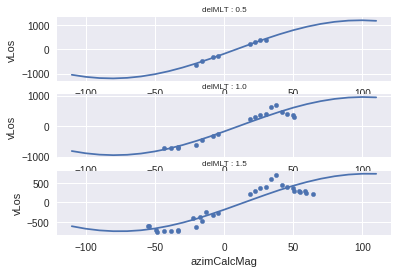

In [6]:
fig = plt.figure()
# Filter out certain unwanted values
azimCharDF = azimCharDF[ (azimCharDF["azimRng"] >= 40.) &\
                       (azimCharDF["countUniqAzims"] >= 5.)].reset_index(drop=True)
# get a list of the uniq MLATs and MLTs
# start fitting values to them
for cl, cm in azimCharDF.groupby( [ "MLAT", "MLT" ] ).groups.keys():
    subDF = azimCharDF[ (azimCharDF["MLAT"] == cl) &\
                      (azimCharDF["MLT"] == cm)]
    # Now for each mlat, mlt and delMLT combination
    # fit sine curves and test their goodness of fit
    if (cl == 58.5 and cm == 0.):
        # plotting
        
        for indValDmlt, dMlt in enumerate(subDF["delMLT"].values):
#             print "curr CELL--->", cl, cm, dMlt
            dfSel = velsDataDF[ (velsDataDF["MLAT"] >= cl - cellSizeMLAT/2.) &\
                              (velsDataDF["MLAT"] < cl + cellSizeMLAT/2.) &\
                            (velsDataDF["normMLT"] >= cm - dMlt) &\
                              (velsDataDF["normMLT"] < cm + dMlt)].reset_index(drop=True)
            popt, pcov = scipy.optimize.curve_fit(vel_sine_func, \
                        dfSel[fitAzmType].T,\
                        dfSel['vLos'].T,
                       p0=initGuess)
            print "Vmax--->", popt[0],"+/-", pcov[0,0]**0.5
            print "delTheta--->", popt[1],"+/-", pcov[1,1]**0.5
            thetaArr = range(-110, 120, 10)
            vLosArr = [ round( model_func(t, popt[0],popt[1]) ) for t in thetaArr ]
            ax = fig.add_subplot(len(subDF["delMLT"].values),1,indValDmlt+1)
            
            dfSel.plot( x=fitAzmType, y="vLos", kind="scatter", ax=ax )
            ax.plot( thetaArr, vLosArr )
            ax.set_title("delMLT : " + str(dMlt), fontsize=8)
fig.savefig( "../figs/allFitsTest.pdf",bbox_inches='tight' )